# Mapa temático de deforestación

# 1. Autenticación de Google Earth Engine

Se utiliza la API de Python de GEE para buscar y descargar imágenes del satélite Sentinel-2. 
`ee`: API de Google Earth Engine para Python, que permite acceder a colecciones de datos satelitales y ejecutar operaciones en la nube.  

In [7]:
# Importar biblioteca de Google Earth Engine
import ee

# Autenticación: Esto abre una ventana en el navegador solicitando acceso a cuenta Google
ee.Authenticate()  
# Inicializar la sesion de Earth Engine
ee.Initialize()

# 2. Importar paqueterías

In [ ]:
import geemap
import ee_extra
import math
import geopandas as gpd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap,BoundaryNorm
from matplotlib.patches import Patch
import rasterio
import folium
import json
import os
from shapely.geometry import mapping, Polygon, MultiPolygon

C:\Users\zaira\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\geemap\conversion.py:23: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


# 3. Definir polígono de interés

En este bloque se establece la ruta local del **polígono de interés (area of interes, AOI)** desde un archivo en formato `.kml` o `.kmz`. 

✏️ Para trabajar con un nuevo polígono solo requiere reemplazar la ruta de la carpeta de trabajo 


In [9]:
ruta_kml = r"C:\Users\zaira\OneDrive - Procuraduria Federal de Proteccion al Ambiente\SIIVDA\Codigos Phyton\Deforestacion - Vegetacion\Cabañas-Terrenate-Tlax_.kml"

# Verificar que el archivo existe
if not os.path.exists(ruta_kml):
    raise FileNotFoundError(f"El archivo no fue encontrado: {ruta_kml}")

# Convertir el archivo KML a GeoJSON para cargarlo en Earth Engine
gdf = gpd.read_file(ruta_kml, driver='KML')
geojson = gdf.geometry[0].__geo_interface__
aoi = ee.Geometry(geojson)
aoi_feature = ee.Feature(aoi)
aoi_fc = ee.FeatureCollection([aoi_feature])
print("✅ Polígono cargado correctamente.")


# Visualizar el polígono en un mapa interactivo con imagen ESRI de fondo
Map = geemap.Map(basemap='Esri.WorldImagery')
Map.centerObject(aoi, zoom=16)
style = {
    'color': 'red',    # Color del contorno
    'width': 3,        # Grosor de la línea
    'fillColor': '00000000'  # Relleno transparente
}
Map.addLayer(aoi_fc.style(**style), {}, 'Contorno AOI (Rojo)')
Map

✅ Polígono cargado correctamente.


Map(center=[19.481693985330033, -97.87640471671325], controls=(WidgetControl(options=['position', 'transparent…

# 4. Estimación de NDVI (Normalized Difference Vegetation Index)

El **NDVI** es un índice utilizado para el monitoreo de vegetación

## Fórmula NDVI:

$$
NDVI = \frac{(NIR - Red)}{(NIR + Red)}
$$

**Donde:**
- *NIR*: Banda infrarroja cercana (Sentinel-2: **B8**)
- *Red*: Banda roja (Sentinel-2: **B4**)

---

## Interpretación general:
- **NDVI ≈ +1** → Vegetación densa y saludable 
- **NDVI ≈ 0** → Suelos desnudos o áreas sin vegetación 
- **NDVI < 0** → Cuerpos de agua, nubes u objetos no vegetales 


## Aplicaciones del NDVI:
a) Clasificación de vegetación.  
b) Monitoreo ambiental [(Jensen, 2000)](https://doi.org/10.1080/014311600210407).  
c) Detección de estrés en cultivos y ecosistemas [(Wang et al., 2022)](https://doi.org/10.1016/j.gecco.2022.e02034).  
d) Alerta temprana de plagas y enfermedades [(Spruce et al., 2011)](https://doi.org/10.1016/j.rse.2010.09.013).  
e) Manejo de recursos hídricos [(Aguilar et al., 2012)](https://doi.org/10.1016/j.ecolind.2012.04.008).  
f) Predicción y monitoreo de incendios forestales [(Charizanos & Demirhan, 2023)](https://doi.org/10.1016/j.ecoinf.2022.101899).




In [10]:
def addNDVI(image):
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
    return image.addBands(ndvi)

## 4.1. Funciones para enmascarar nubes y nieve/hielo en imágenes Sentinel-2

En este bloque se define una función para eliminar píxeles de nubes y nieve/hielo en imágenes Sentinel-2. Esto es crucial para mejorar la calidad de los análisis de índices de vegetación como NDVI, especialmente en zonas costeras donde la presencia de agua y bruma puede provocar errores en las máscaras estándar. 

###  **Función 1: Enmascarado usando bandas probabilísticas**

1. Se usa la banda `MSK_CLDPRB` (Cloud Probability Mask) para excluir áreas con alta probabilidad de nubes.  
2. Se usa la banda `MSK_SNWPRB` (Snow Probability Mask) para excluir áreas con alta probabilidad de nieve/hielo.  
3. Se combina la máscara y se aplica sobre la imagen original mediante `.updateMask()`.

---

In [18]:
# Función 1: Enmascarar nubes y nieve/hielo usando probabilidades

# Los umbrales de nubes y nieve se pueden ajustar ✏️
def maskS2clouds_coastal(image, cloud_thresh=10, snow_thresh=20):
   
    # Seleccionar la banda de probabilidad de nubes
    clouds = image.select('MSK_CLDPRB')
    
    # Enmascarar áreas con probabilidad de nubes mayor al umbral
    mask = clouds.lt(cloud_thresh)
    
    # Enmascarar áreas con probabilidad de nieve mayor al umbral
    snow = image.select('MSK_SNWPRB')
    mask = mask.And(snow.lt(snow_thresh))
    
    # Aplicar la máscara a la imagen
    return image.updateMask(mask)



### 🌫️ **Función 2: Enmascarado usando Scene Classification Layer (SCL)**
Esta función utiliza la banda `SCL` (*Scene Classification Layer*) para excluir píxeles identificados como:  
- **3** = Sombras de nubes.  
- **8, 9** = Nubes (probabilidad media/alta).  
- **10** = Cirros delgados.  
- **11** = Nieve/Hielo.  

Este método es más robusto para eliminar **sombras de nubes**, que suelen confundirse con vegetación en índices como NDVI.

---

📖 **Referencias:**
- ESA (2015). Sentinel-2 User Handbook. [Link](https://sentinel.esa.int/documents/247904/685211/Sentinel-2_User_Handbook).  
- Google Earth Engine Docs: [Sentinel-2 SR Harmonized](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR_HARMONIZED).  
- Zhu & Woodcock (2012). Object-based cloud and cloud shadow detection in Landsat imagery. *Remote Sensing of Environment*, 118, 83–94. [DOI](https://doi.org/10.1016/j.rse.2011.10.028).  


In [ ]:
# Funcion 2:  Enmascarar nubes y sombras usando Scene Classification Layer (SCL)

def maskS2clouds_SCL(image):

    # Seleccionar la banda de clasificación SCL
    scl = image.select('SCL')

    # Definir las clases a enmascarar:
    # 3 = Cloud Shadow, 8 = Clouds (Medium Probability), 9 = Clouds (High Probability),
    # 10 = Thin Cirrus, 11 = Snow/Ice
    mask = scl.neq(3).And(
        scl.neq(8)).And(
        scl.neq(9)).And(
        scl.neq(10)).And(
        scl.neq(11))
    
    # Aplicar la máscara
    return image.updateMask(mask)

print("✅ Funciones de enmascarado definidas correctamente.")

✅ Funciones de enmascarado definidas correctamente.


 # 6: Selección de periodos y ajuste dinámico de nubosidad según la estación

Se configura el **periodo de análisis** (años y meses) y se ajusta automáticamente el porcentaje máximo de nubosidad permitido según la estación:

- 🌧️ **Época de lluvias (junio-noviembre):** Se permite hasta un **30% de nubosidad**, ya que las condiciones atmosféricas suelen ser más húmedas y nubladas.  
- ☀️ **Época seca (diciembre-mayo):** Se usa un umbral más estricto (**10-20%**) para asegurar imágenes limpias.  

---

1. El usuario define los años y meses de interés en las variables `años`, `mes_inicio`, y `mes_fin`.  
2. La función `definir_nubosidad()` evalúa la estación y ajusta dinámicamente el umbral de nubosidad.  
3. Se filtra la colección Sentinel-2 por año y se aplica:
   - **Enmascarado de nubes/nieve** (`maskS2clouds_coastal`).
   - **Cálculo del NDVI** (`addNDVI`).
4. Los resultados se almacenan en un diccionario `colecciones_filtradas` para uso posterior.

📖 **Referencias:**
- ESA (2015). Sentinel-2 User Handbook.  
- Google Earth Engine Docs: [FilterDate()](https://developers.google.com/earth-engine/apidocs/ee-imagecollection-filterdate).  


In [21]:

# ✏️ EDITAR: Definir años y meses de interés
años = [2020, 2021, 2022, 2023, 2024]  # Lista de años a evaluar ✏️
mes_inicio, mes_fin = 1, 12             # Intervalo de meses (1-12)
print(f"📅 Periodo seleccionado: Meses {mes_inicio}-{mes_fin}, Años {años}")

# Validación de rangos
assert 1 <= mes_inicio <= 12 and 1 <= mes_fin <= 12, "Mes fuera de rango (1-12)"
assert mes_inicio <= mes_fin, "mes_inicio debe ser ≤ mes_fin"

# Función para definir el porcentaje máximo de nubosidad según estación
def definir_nubosidad(mes_inicio, mes_fin):
    """
    Ajusta el porcentaje máximo de nubosidad permitido según la estación:
    - Época de lluvias (junio-noviembre): 30%
    - Época seca (diciembre-mayo): 10-20%
    """
    meses_lluvia = list(range(6, 12 + 1))  # Junio a Noviembre
    # Si el rango de meses incluye alguno de lluvias
    if any(mes in meses_lluvia for mes in range(mes_inicio, mes_fin + 1)):
        return 30  # Permitir más nubosidad
    else:
        return 15  # Más estricto en época seca

# Determinar porcentaje de nubosidad para el periodo seleccionado
nubosidad_max = definir_nubosidad(mes_inicio, mes_fin)
print(f"☁️ Porcentaje máximo de nubosidad permitido: {nubosidad_max}%")

# Diccionario para almacenar las colecciones Sentinel-2 filtradas por año
colecciones_filtradas = {}

# Filtrar imágenes por año y meses, aplicar enmascarado y almacenar en el diccionario
for año in años:
    fecha_inicio = ee.Date.fromYMD(año, mes_inicio, 1)
    fecha_fin = ee.Date.fromYMD(año, mes_fin, 28)  # Día 28 para evitar problemas de febrero

    # Filtrar colección Sentinel-2
    coleccion = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
                 .filterBounds(aoi)
                 .filterDate(fecha_inicio, fecha_fin)
                 .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', nubosidad_max))
                 .map(maskS2clouds_coastal)  # Aplicar función de enmascarado
                 .map(addNDVI)               # Calcular NDVI
                )

    colecciones_filtradas[año] = coleccion
    print(f"✅ Año {año}: {coleccion.size().getInfo()} imágenes filtradas.")

print("🎯 Colecciones Sentinel-2 preparadas por año.")


📅 Periodo seleccionado: Meses 1-12, Años [2020, 2021, 2022, 2023, 2024]
☁️ Porcentaje máximo de nubosidad permitido: 30%
✅ Año 2020: 101 imágenes filtradas.
✅ Año 2021: 90 imágenes filtradas.
✅ Año 2022: 81 imágenes filtradas.
✅ Año 2023: 92 imágenes filtradas.
✅ Año 2024: 92 imágenes filtradas.
🎯 Colecciones Sentinel-2 preparadas por año.


# 7. Estadísticos de validación por año

 Metricas que permiten evaluar la calidad de los datos y confirmar que el filtrado por nubosidad y el enmascarado funcionaron correctamente.

### Estadísticas calculadas:
- **NDVI mínimo y máximo**: Indican el rango de valores presentes en el área de interés (AOI).  
- **NDVI medio y desviación estándar**: Reflejan la cobertura vegetal promedio y la heterogeneidad en el AOI.  
- **Número de imágenes**: Cantidad de imágenes usadas para generar el mosaico por año.

**Referencias:**
- Huete, A., et al. (2002). Overview of the radiometric and biophysical performance of the MODIS vegetation indices. *Remote Sensing of Environment*, 83(1-2), 195–213.  
- Google Earth Engine Docs: [reduceRegion()](https://developers.google.com/earth-engine/apidocs/ee-image-reduceregion).

In [23]:

# Lista para almacenar resultados por año
resumen_stats = []

# Iterar sobre los años filtrados
for año, coleccion in colecciones_filtradas.items():
    # Crear un mosaico NDVI para el año (media de las imágenes)
    ndvi_mosaico = coleccion.select('NDVI').mean().clip(aoi)
    
    # Reducir a estadísticas sobre el AOI
    stats = ndvi_mosaico.reduceRegion(
        reducer=ee.Reducer.minMax()
                      .combine(reducer2=ee.Reducer.mean(), sharedInputs=True)
                      .combine(reducer2=ee.Reducer.stdDev(), sharedInputs=True),
        geometry=aoi,
        scale=10,
        maxPixels=1e9
    ).getInfo()

    resumen_stats.append({
        "Año": año,
        "NDVI_min": stats.get("NDVI_min", None),
        "NDVI_max": stats.get("NDVI_max", None),
        "NDVI_media": stats.get("NDVI_mean", None),
        "NDVI_stdDev": stats.get("NDVI_stdDev", None),
        "N_imagenes": coleccion.size().getInfo()
    })

# Convertir a DataFrame para visualizar
df_resumen = pd.DataFrame(resumen_stats)
display(df_resumen)


,Año,NDVI_min,NDVI_max,NDVI_media,NDVI_stdDev,N_imagenes
0,2020,0.299941,0.704993,0.500611,0.086231,101
1,2021,0.246454,0.671284,0.480387,0.086720,90
2,2022,0.025374,0.710256,0.449533,0.100945,81
3,2023,0.035709,0.667521,0.445574,0.100515,92
4,2024,0.046043,0.636456,0.430419,0.089479,92


### Interpretación
NDVI_media va disminuyendo ligeramente de 2020 (0.50) a 2024 (0.43).
NDVI_stdDev es relativamente constante (~0.08-0.10), lo que indica que la heterogeneidad del paisaje no varía tanto entre años.
N_imagenes es alto (81–101), lo cual confirma que el filtro de nubosidad no está excluyendo demasiado material y que tenemos mosaicos robustos.
Los valores NDVI_min bajos en 2022 y 2023 (~0.02-0.03) sugieren presencia de áreas sin vegetación (agua, suelo desnudo o nubes residuales).

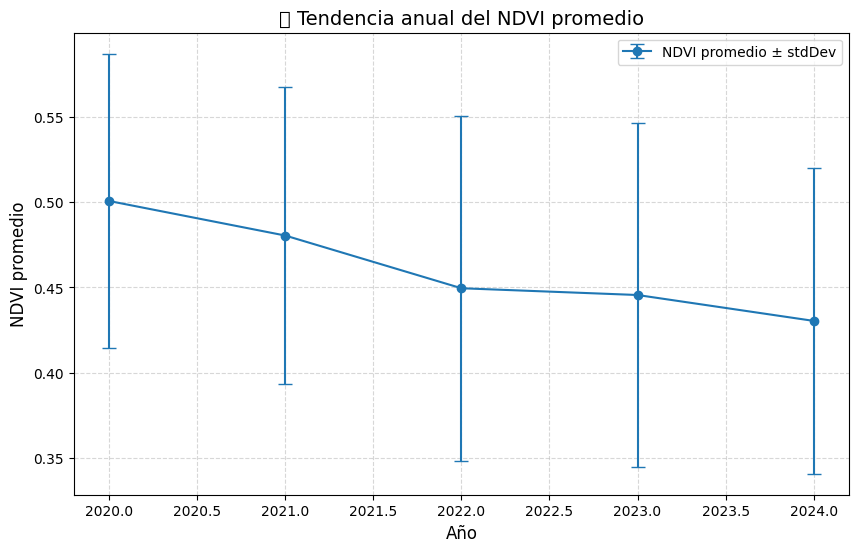

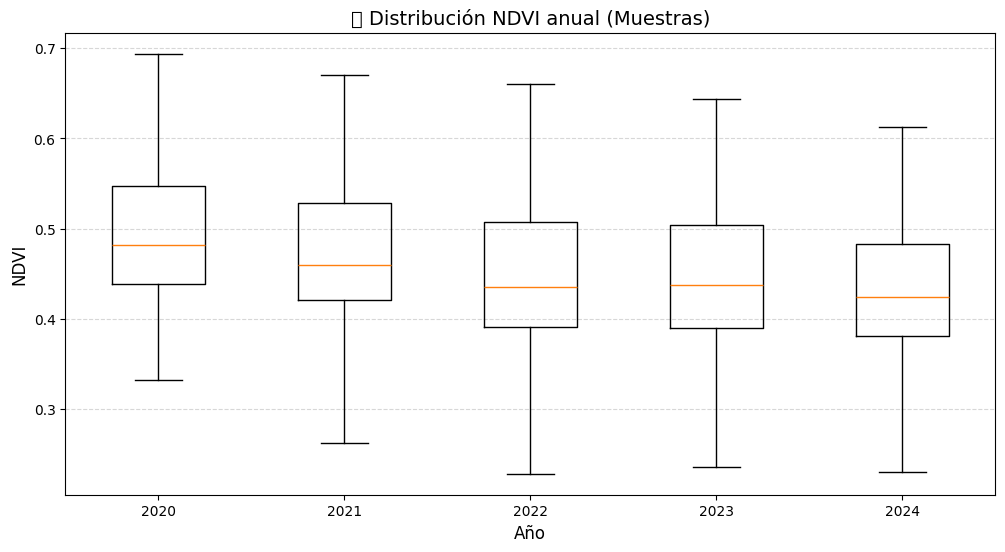

In [24]:
# Configurar tamaño del gráfico
plt.figure(figsize=(10, 6))

# Línea de tendencia NDVI_media con barras de desviación estándar
plt.errorbar(
    df_resumen["Año"], df_resumen["NDVI_media"],
    yerr=df_resumen["NDVI_stdDev"],
    fmt='-o', capsize=5, capthick=1, label="NDVI promedio ± stdDev"
)

# Etiquetas y título
plt.title("📈 Tendencia anual del NDVI promedio", fontsize=14)
plt.xlabel("Año", fontsize=12)
plt.ylabel("NDVI promedio", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()

# Boxplot comparativo NDVI por año (muestra rápida con 1% de los datos)
plt.figure(figsize=(12, 6))

# Extraer muestras de NDVI para boxplot
muestras = []
etiquetas = []
for año, coleccion in colecciones_filtradas.items():
    # Generar mosaico anual
    ndvi_mosaico = coleccion.select('NDVI').mean().clip(aoi)
    # Extraer valores NDVI al azar (muestra para visualización)
    sample = ndvi_mosaico.sample(region=aoi, scale=10, numPixels=500, geometries=False).aggregate_array('NDVI').getInfo()
    muestras.append(sample)
    etiquetas.append(str(año))

# Crear boxplot
plt.boxplot(muestras, labels=etiquetas, showfliers=False)
plt.title("📦 Distribución NDVI anual (Muestras)", fontsize=14)
plt.xlabel("Año", fontsize=12)
plt.ylabel("NDVI", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


### Interpretación

#### Tendencia anual del NDVI promedio
    El NDVI promedio disminuye ligeramente de 2020 (~0.50) a 2024 (~0.43).
    Las barras de desviación estándar son relativamente estables (~0.08–0.10), lo que sugiere que la variabilidad anual del NDVI no cambia drásticamente.

**Esta tendencia podría indicar:**
    Pérdida progresiva de cobertura vegetal (deforestación, degradación, cambio de uso de suelo).
    Efectos climáticos (sequías, variaciones interanuales).

#### Boxplots NDVI por año
    Las medianas de NDVI siguen el mismo patrón de descenso.
    Los rangos intercuartílicos se mantienen similares, pero hay valores mínimos más bajos en 2022–2024, lo que sugiere que hay más áreas con NDVI muy bajo (suelo desnudo, agua o nubes residuales).

**Esta tendencia podría indicar:**
    Menor proporción de vegetación saludable en los años recientes.
    Los valores mínimos muy bajos pueden deberse a:
    Zonas de agua y suelo desnudo reales.

---


## 7.1. Validar la máscara de nubes y sombras

En este bloque se visualizan mosaicos RGB y NDVI para confirmar que:
- Las funciones de enmascarado eliminaron correctamente nubes y sombras.
- No hay áreas enmascaradas de forma excesiva que limiten el análisis.
- Las imágenes combinadas (mosaico) son representativas del periodo seleccionado.

In [33]:
for año, coleccion in colecciones_filtradas.items():
    num_imgs = coleccion.size().getInfo()
    print(f"📅 Año {año}: {num_imgs} imágenes disponibles")

📅 Año 2020: 101 imágenes disponibles
📅 Año 2021: 90 imágenes disponibles
📅 Año 2022: 81 imágenes disponibles
📅 Año 2023: 92 imágenes disponibles
📅 Año 2024: 92 imágenes disponibles


In [43]:
# Diagnóstico rápido: visualizar mosaicos RGB crudos

# Crear mapa
Map_diag = geemap.Map(basemap='Esri.WorldImagery')
Map_diag.centerObject(aoi, zoom=15)

# Mosaico RGB sin aplicar máscara
for año in [2020, 2021, 2022, 2023, 2024, 2025]:
    coleccion_cruda = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
                       .filterBounds(aoi)
                       .filterDate(f"{año}-01-01", f"{año}-12-31")
                       .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 50)))  # Filtro relajado

    rgb_mosaico = coleccion_cruda.select(['B4', 'B3', 'B2']).median().clip(aoi)

    vis_rgb = {'min': 0, 'max': 3000, 'bands': ['B4', 'B3', 'B2']}
    Map_diag.addLayer(rgb_mosaico, vis_rgb, f'RGB {año} (Sin máscara)')

# Mostrar AOI
style = {'color': 'red', 'width': 2, 'fillColor': '00000000'}
Map_diag.addLayer(ee.FeatureCollection(aoi).style(**style), {}, 'AOI')

# Mostrar mapa
Map_diag


Map(center=[19.481693985330033, -97.87640471671325], controls=(WidgetControl(options=['position', 'transparent…

In [45]:
# Visualizar mosaicos NDVI procesados con máscaras y filtros por temporada

# Crear mapa interactivo
Map_NDVI_final = geemap.Map(basemap='Esri.WorldImagery')
Map_NDVI_final.centerObject(aoi, zoom=17)

# Visualizar mosaicos NDVI anuales procesados
for año, coleccion in colecciones_filtradas.items():
    # Crear mosaico NDVI a partir de las imágenes ya filtradas y enmascaradas
    ndvi_mosaico = coleccion.select('NDVI').median().clip(aoi)

    # Parámetros de visualización para NDVI
    vis_ndvi = {
        'min': 0,
        'max': 1,
        'palette': ['brown', 'yellow', 'green']  # Vegetación de baja a alta
    }

    # Añadir mosaico al mapa
    Map_NDVI_final.addLayer(ndvi_mosaico, vis_ndvi, f'NDVI {año} (procesado)')

# Añadir contorno del AOI en rojo
style = {'color': 'red', 'width': 2, 'fillColor': '00000000'}
Map_NDVI_final.addLayer(ee.FeatureCollection(aoi).style(**style), {}, 'AOI')

# Mostrar mapa interactivo
Map_NDVI_final


Map(center=[19.481693985330033, -97.87640471671325], controls=(WidgetControl(options=['position', 'transparent…

## 7.2. Visualizar mosaicos NDVI anuales y por temporada (seca y lluvias)

### 🎨 **Paleta de colores para NDVI**

| Color  | Intervalo NDVI | Interpretación                 |
|--------|----------------|----------------------------------|
| 🟫 Brown | 0.0 – 0.2      | Suelo desnudo, agua, áreas sin vegetación |
| 🟨 Yellow| 0.2 – 0.5      | Vegetación moderada (pastizales, cultivos) |
| 🟩 Green | 0.5 – 1.0      | Vegetación densa (bosques, selvas)         |

---

### **Capas visualizadas**
1. **NDVI anual (enero-diciembre):** Mosaico con todas las imágenes del año, útil para un panorama general.  
2. **Temporada seca (diciembre-mayo):** 
   - Se usa un filtro estricto de nubosidad (**<15%**) para asegurar imágenes limpias.  
3. **Temporada de lluvias (junio-noviembre):** 
   - Se permite mayor nubosidad (**<30%**) debido a las condiciones atmosféricas de la época.  

---

📖 **Referencias técnicas:**
- ESA (2015). *Sentinel-2 User Handbook*.  
- Google Earth Engine Docs: [NDVI Calculation](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR_HARMONIZED).  


In [61]:

# Crear mapa interactivo
Map_NDVI_epocas = geemap.Map(basemap='Esri.WorldImagery')
Map_NDVI_epocas.centerObject(aoi, zoom=12)

# Parámetros de visualización para NDVI
vis_ndvi = {
    'min': 0,
    'max': 1,
    'palette': ['brown', 'yellow', 'green']  # Vegetación de baja a alta
}

# Iterar sobre años y mostrar NDVI anuales y por temporada
for año in años:
    # Filtrar colección para todo el año
    coleccion_anual = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
                       .filterBounds(aoi)
                       .filterDate(f"{año}-01-01", f"{año}-12-31")
                       .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', definir_nubosidad(1, 12)))
                       .map(maskS2clouds_coastal)
                       .map(addNDVI))

    # Mosaico NDVI anual
    ndvi_anual = coleccion_anual.select('NDVI').median().clip(aoi)
    Map_NDVI_epocas.addLayer(ndvi_anual, vis_ndvi, f'NDVI {año} (anual)')

    # Temporada seca (dic-may)
    coleccion_seca = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
                      .filterBounds(aoi)
                      .filterDate(f"{año}-01-01", f"{año}-05-31")
                      .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 15))  # Más estricto en seca
                      .map(maskS2clouds_coastal)
                      .map(addNDVI))

    ndvi_seca = coleccion_seca.select('NDVI').median().clip(aoi)
    Map_NDVI_epocas.addLayer(ndvi_seca, vis_ndvi, f'NDVI {año} (seca)')

    # Temporada de lluvias (jun-nov)
    coleccion_lluvias = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
                         .filterBounds(aoi)
                         .filterDate(f"{año}-06-01", f"{año}-11-30")
                         .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 30))  # Más permisivo en lluvias
                         .map(maskS2clouds_coastal)
                         .map(addNDVI))

    ndvi_lluvias = coleccion_lluvias.select('NDVI').median().clip(aoi)
    Map_NDVI_epocas.addLayer(ndvi_lluvias, vis_ndvi, f'NDVI {año} (lluvias)')

# Añadir contorno del AOI en rojo
style = {'color': 'red', 'width': 2, 'fillColor': '00000000'}
Map_NDVI_epocas.addLayer(ee.FeatureCollection(aoi).style(**style), {}, 'AOI')

# Mostrar mapa interactivo
Map_NDVI_epocas


Map(center=[19.481693985330033, -97.87640471671325], controls=(WidgetControl(options=['position', 'transparent…

In [57]:
# Estadísticas NDVI por época y gráfica de validación

# Lista para guardar estadísticas
stats_epocas = []

# Iterar sobre los años
for año in años:
    for epoca, (mes_ini, mes_fin, nubosidad) in {
        "Seca": (1, 5, 15),         # Temporada seca: enero-mayo, nubosidad estricta
        "Lluvias": (6, 11, 30)      # Temporada lluvias: junio-noviembre, nubosidad permisiva
    }.items():
        # Filtrar colección para la época y aplicar máscara
        coleccion_epoca = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
                           .filterBounds(aoi)
                           .filterDate(f"{año}-{mes_ini:02d}-01", f"{año}-{mes_fin:02d}-28")
                           .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', nubosidad))
                           .map(maskS2clouds_coastal)
                           .map(addNDVI))

        # Crear mosaico NDVI para la época
        ndvi_mosaico = coleccion_epoca.select('NDVI').median().clip(aoi)

        # Reducir a estadísticas
        stats = ndvi_mosaico.reduceRegion(
            reducer=ee.Reducer.minMax()
                          .combine(reducer2=ee.Reducer.mean(), sharedInputs=True)
                          .combine(reducer2=ee.Reducer.stdDev(), sharedInputs=True),
            geometry=aoi,
            scale=10,
            maxPixels=1e9
        ).getInfo()

        # Guardar resultados
        stats_epocas.append({
            "Año": año,
            "Época": epoca,
            "NDVI_min": stats.get("NDVI_min", None),
            "NDVI_max": stats.get("NDVI_max", None),
            "NDVI_media": stats.get("NDVI_mean", None),
            "NDVI_stdDev": stats.get("NDVI_stdDev", None),
            "N_imagenes": coleccion_epoca.size().getInfo()
        })

# Convertir a DataFrame
df_epocas = pd.DataFrame(stats_epocas)

# Mostrar tabla
display(df_epocas)


,Año,Época,NDVI_min,NDVI_max,NDVI_media,NDVI_stdDev,N_imagenes
0,2020,Seca,0.238721,0.698584,0.466723,0.099812,37
1,2020,Lluvias,0.372772,0.801968,0.574652,0.082201,42
2,2021,Seca,0.197911,0.683935,0.431711,0.106680,34
3,2021,Lluvias,0.206025,0.826919,0.581769,0.086947,30
4,2022,Seca,0.024319,0.736843,0.444124,0.117483,32
5,2022,Lluvias,0.027464,0.753220,0.464342,0.099153,29
6,2023,Seca,0.019194,0.665114,0.418564,0.113161,36
7,2023,Lluvias,0.031359,0.770762,0.490986,0.103012,37
8,2024,Seca,0.014480,0.624688,0.370821,0.107151,41
9,2024,Lluvias,0.033708,0.799995,0.535596,0.092027,33


## 7.3. Gráficas NDVI promedio por año para cada temporada

 ### 🌞 **Temporada seca (Enero–Mayo)**
- NDVI promedio calculado para la estación seca de cada año.
- Barra de error: desviación estándar del NDVI en el AOI.  

🎨 **Color:** Amarillo (`#f1c40f`)  

---

### 🌧️ **Temporada de lluvias (Junio–Noviembre)**
- NDVI promedio calculado para la estación lluviosa de cada año.
- Barra de error: desviación estándar del NDVI en el AOI.  

🎨 **Color:** Azul (`#3498db`)  

---

 **Interpretación**:  
- Las gráficas permiten comparar la variabilidad interanual del vigor vegetativo en cada temporada.  
- Diferencias significativas entre años pueden reflejar efectos de clima, uso de suelo o degradación.  




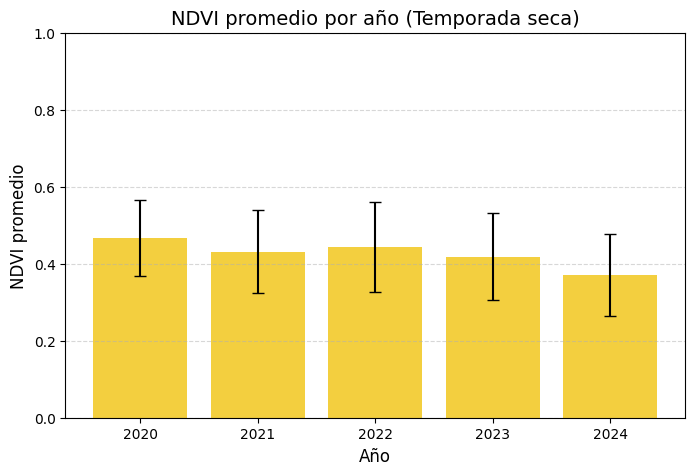

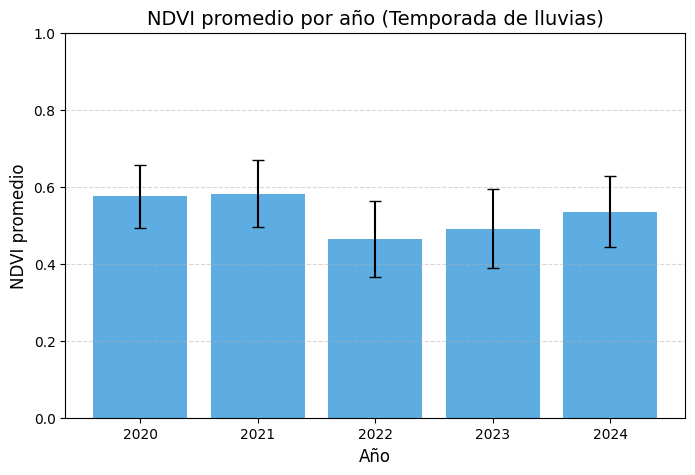

In [59]:
# Filtrar datos por época
df_seca = df_epocas[df_epocas["Época"] == "Seca"]
df_lluvias = df_epocas[df_epocas["Época"] == "Lluvias"]

# -------------------------------
# 🌞 Gráfica temporada seca
# -------------------------------
plt.figure(figsize=(8, 5))
plt.bar(df_seca["Año"], df_seca["NDVI_media"], 
        yerr=df_seca["NDVI_stdDev"],
        color="#f1c40f", alpha=0.8, capsize=4)

plt.title("NDVI promedio por año (Temporada seca)", fontsize=14)
plt.xlabel("Año", fontsize=12)
plt.ylabel("NDVI promedio", fontsize=12)
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Mostrar gráfico
plt.show()

# -------------------------------
# 🌧️ Gráfica temporada lluvias
# -------------------------------
plt.figure(figsize=(8, 5))
plt.bar(df_lluvias["Año"], df_lluvias["NDVI_media"], 
        yerr=df_lluvias["NDVI_stdDev"],
        color="#3498db", alpha=0.8, capsize=4)

plt.title("NDVI promedio por año (Temporada de lluvias)", fontsize=14)
plt.xlabel("Año", fontsize=12)
plt.ylabel("NDVI promedio", fontsize=12)
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Mostrar gráfico
plt.show()
